In [1]:
import sys, os
sys.path.append("..")

import pandas as pd
import numpy as np

from agents import StrategyAgent, RiskAgent, AllocatorAgent, ReflectionAgent, MemoryAgent


Portfolio Manager Agent
Starts the workflow.

Calls StrategyAgent to propose.

Uses RiskAgent to filter.

Uses AllocatorAgent to build portfolio.

If fail → asks ReflectionAgent to adjust parameters.

Uses MemoryAgent to avoid repeating mistakes.

Returns final decision + logs.

In [3]:
class PortfolioManagerAgent:
    def __init__(self, data, max_attempts=5):
        self.data = data
        self.max_attempts = max_attempts
        self.memory = MemoryAgent()
        self.reflection = ReflectionAgent()
        self.risk = RiskAgent(sharpe_min=1.0, max_dd=-0.25, vol_max=0.3)
    
    def compute_metrics(self, df):
        col = "Strategy_Return" if "Strategy_Return" in df.columns else "Portfolio_Return"
        returns = df[col].fillna(0)
        strat_curve = (1 + returns).cumprod()
        years = (returns.index[-1] - returns.index[0]).days / 365.25
        cagr = strat_curve.iloc[-1]**(1/years) - 1 if years > 0 else 0
        vol = returns.std() * np.sqrt(252)
        sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
        roll_max = strat_curve.cummax()
        dd = (strat_curve / roll_max - 1).min()
        return {"CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "MaxDD": dd}
    
    def run(self):
        attempt = 0
        decision = "FAIL"
        portfolio = None
        alloc_method = "sharpe"
        sma_fast, sma_slow = 10, 50
        rsi_lower, rsi_upper = 30, 70
        reflections = []
        
        while attempt < self.max_attempts and decision == "FAIL":
            attempt += 1
            print(f"\n=== Attempt {attempt} ===")
            
            # Step 1: Strategies
            sa = StrategyAgent(self.data)
            strategies = {
                "SMA": sa.sma_crossover(fast=sma_fast, slow=sma_slow),
                "RSI": sa.rsi_strategy(lower=rsi_lower, upper=rsi_upper),
                "BB": sa.bollinger_breakout()
            }
            
            # Step 2: Metrics
            metrics = {n: self.compute_metrics(df) for n, df in strategies.items()}
            
            # Step 3: Risk check
            assessments = {n: self.risk.assess(m) for n, m in metrics.items()}
            
            # Step 4: Allocation
            alloc = AllocatorAgent(method=alloc_method)
            weights, portfolio = alloc.allocate(strategies, metrics, assessments)
            
            if portfolio is None:
                print("No portfolio created, skipping to next attempt.")
                continue
            
            # Step 5: Portfolio-level risk
            portfolio_metrics = self.compute_metrics(portfolio)
            portfolio_assessment = self.risk.assess(portfolio_metrics)
            print("Portfolio metrics:", portfolio_metrics)
            print("Assessment:", portfolio_assessment)
            
            decision = portfolio_assessment["Decision"]
            
            # Memory logging
            for n, m in metrics.items():
                self.memory.record(n, m, assessments[n])
            self.memory.record("PORTFOLIO", portfolio_metrics, portfolio_assessment)
            
            # Reflection if fail
            if decision == "FAIL":
                feedback = self.reflection.reflect(portfolio_assessment)
                reflections.append(feedback)
                print("Reflection:", feedback)
                
                if "sma_slow" in feedback["New_Params"]:
                    sma_slow = feedback["New_Params"]["sma_slow"]
                if "rsi_lower" in feedback["New_Params"]:
                    rsi_lower = feedback["New_Params"]["rsi_lower"]
                if "rsi_upper" in feedback["New_Params"]:
                    rsi_upper = feedback["New_Params"]["rsi_upper"]
                if "allocation" in feedback["New_Params"]:
                    alloc_method = feedback["New_Params"]["allocation"]
        
        return portfolio, decision, reflections, self.memory



=== Attempt 1 ===
Portfolio metrics: {'CAGR': np.float64(0.13984910882294188), 'Volatility': np.float64(0.04382244081992633), 'Sharpe': np.float64(2.9944674019850326), 'MaxDD': np.float64(-0.007035576834644064)}
Assessment: {'Decision': 'PASS', 'Notes': ['All risk checks passed']}

Final Decision: PASS
Reflections: []
Memory size: 4


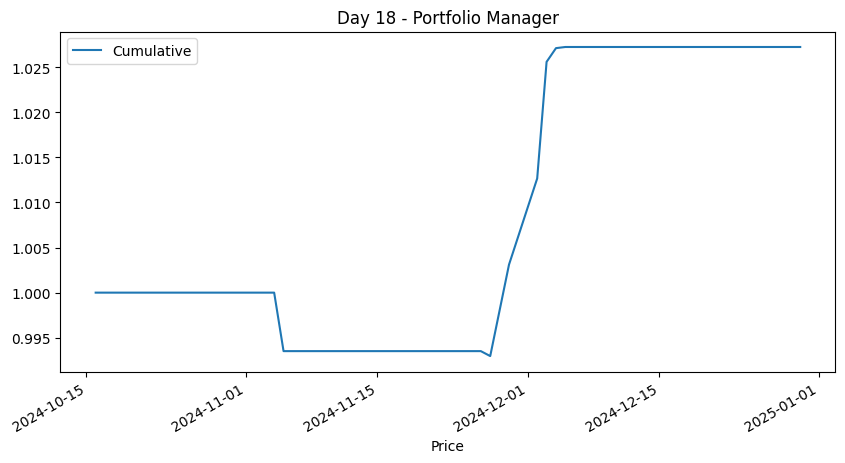

In [4]:
data = pd.read_csv("../data/AAPL_enriched.csv", index_col=0, parse_dates=True)

pm = PortfolioManagerAgent(data)
portfolio, decision, reflections, memory = pm.run()

print("\nFinal Decision:", decision)
print("Reflections:", reflections)
print("Memory size:", len(memory.history))

if portfolio is not None:
    portfolio[["Cumulative"]].plot(title="Day 18 - Portfolio Manager", figsize=(10,5))


In [5]:
os.makedirs("../logs", exist_ok=True)

portfolio.to_csv("../logs/Day18_portfolio.csv")
memory.export("../logs/Day18_memory.csv")

with open("../logs/Day18_summary.txt", "w") as f:
    f.write("Day 18 run with PortfolioManagerAgent\n")
    f.write(f"Decision: {decision}\n")
    f.write("Reflections:\n")
    for r in reflections:
        f.write(str(r) + "\n")
